# Random Forest

В этом эксперименте мы познакомимся с классификатором "Случайный лес". Будем измерять качество классификатора метрикой accuracy при проведении кросс-валидации на 10 фолдов.

In [190]:
from sklearn import datasets, tree, model_selection, ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

Загрузим датасет digits из sklearn

In [157]:
digits = datasets.load_digits()

In [158]:
type(digits)

sklearn.utils.Bunch

In [159]:
digits.DESCR

".. _digits_dataset:\n\nOptical recognition of handwritten digits dataset\n--------------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 5620\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttp://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixels

## Оптическое распознавание рукописных цифр
### Характеристики дата-сета:
Количество экземпляров: 5620

Количество атрибутов (признаков): 64

Информация об атрибутах: Изображение 8x8 целых пикселей в диапазоне 0..16

Пропущенные (недостающие) значения атрибута: None

Автор: E. Alpaydin (alpaydin '@' boun.edu.tr)

Дата: 1998.07

Это копия тестового набора рукописных цифр UCI ML (http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)

Набор данных содержит изображения рукописных цифр: 10 классов, где каждый класс относится к цифре.

Для извлечения нормализованных растровых изображений рукописных цифр из предварительно напечатанной формы, использовались программы предварительной предобработки предоставленные NIST.


Из 43 человек 30 участвовали в тренировочном наборе, а 13 - в тестовом наборе.

Битовые карты 32x32 делятся на неперекрывающиеся блоки 4x4, при этом количество пикселей учитывается в каждом блоке. Генерируется входная матрица 8x8, где каждый элемент является целым числом в диапазоне 0..16. Таким образом, уменьшается размерность и добавляется инвариантность к небольшим искажениям.

Для получения информации о процедурах предварительной обработки NIST смотри: M.D. Garris, J.L. Blue, G.T. Candela, D.L. Dimmick, J.Geist, P.J. Grother, S.A. Janet, and C.L. Wilson

Система распознавания отпечатков пальцев на основе форм NIST, NISTIR 5469, 1994

### Ссылки:
01 C. Kaynak (1995) Methods of Combining Multiple Classifiers and Their Applications to Handwritten Digit Recognition

*Методы объединения нескольких классификаторов и их приложений для распознавания рукописных цифр*

02 C. Kaynak (1998) Cascading Classifiers, Kybernetika

*Каскадные классификаторы, Кибернетика*

03 E.K. Tang, P.N. Suganthan, X. Yao, A.K. Qin. (2005) Linear dimensionalityreduction using relevance weighted LDA

School of Electrical and Electronic Engineering Nanyang Technological University

04 C. Gentile (2005) A New Approximate Maximal Margin Classification, Algorithm NIPS

In [160]:
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

Выделим из датасета матрицу признаков и вектор ответов

In [161]:
x_data = digits.data
y = digits.target

Установим размер матрицы признаков и вектора ответов

In [162]:
print x_data.shape
print y.shape

(1797L, 64L)
(1797L,)


Выведем классы объектов

In [163]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

У нас 10 классов объектов, столько же, сколько и цифр. Логично!

Выведем список возможных значений признаков матрицы X

In [164]:
np.unique(x_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

Всего 16+1=17 значений

При это нулевой признак имеет одно значение - ноль, первый признак представлен 8+1=9 значениями, каждый из остальных признаков обладает 16+1=17 значениями

In [165]:
print np.unique(x_data[:,0])

print np.unique(x_data[:,1])

print np.unique(x_data[:,2])

[0.]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


Проверим балансировку классов

In [166]:
balance = []
for i in np.unique(y):
    cell = np.array([])
    cell.resize((1,2))
    cell[0][0] = i
    cell[0][1] = np.sum(y==i)
    balance.append(cell)

balance

[array([[  0., 178.]]),
 array([[  1., 182.]]),
 array([[  2., 177.]]),
 array([[  3., 183.]]),
 array([[  4., 181.]]),
 array([[  5., 182.]]),
 array([[  6., 181.]]),
 array([[  7., 179.]]),
 array([[  8., 174.]]),
 array([[  9., 180.]])]

In [167]:
balance = np.array(balance)

np.sum(balance[:,0][:,1])

balance_perc = []
for i in balance:
        cell = np.array([])
        cell.resize((1,2))
        cell[0][0] = i[0][0]
        cell[0][1] = round(i[0][1]*100/np.sum(balance[:,0][:,1]),1)
        balance_perc.append(cell)
balance_perc

[array([[0. , 9.9]]),
 array([[ 1. , 10.1]]),
 array([[2. , 9.8]]),
 array([[ 3. , 10.2]]),
 array([[ 4. , 10.1]]),
 array([[ 5. , 10.1]]),
 array([[ 6. , 10.1]]),
 array([[ 7., 10.]]),
 array([[8. , 9.7]]),
 array([[ 9., 10.]])]

Объекты сбалансированы по классам. Проводить балансировку не требуется. Данные пригодны для дальнейшего обучения

## Исследование 1
Выберем в качестве алгоритма классификации объектов - Дерево решений (DecisionTreeClassifier, модуля Tree, библиотеки Sklearn) 

Метрику качества будем оценивать при использовании кросс-валидации на 10 фолдов (метод cross_val_score, модуля model_selection, библиотеки sklearn). Метрика качества настроена по умолчанию, которую использует модель классификатора - accuracy

Запишем каждое из 10 значений метрики качества и рассчитаем среднее accuracy

In [168]:
# инициилизируем классификатор Дерево решений
model = tree.DecisionTreeClassifier()

# задаем стратегию кросс-валидации и обучаем модель
name_strategy_cv_1 = ('Модель: Одно дерево')
strategy_cv_1 = model_selection.cross_val_score(model, x_data, y, cv=10)

# напишем функцию быстрой записи ответа
def write_answer(name_strategy_cv, strategy_cv, number_of_answer):
    print name_strategy_cv
    print 'Вектор оценок accuracy:', map(lambda x: round(x,2), strategy_cv)
    with open("answer%s.txt" % number_of_answer, "w") as fout:
        fout.write(str(np.mean(strategy_cv)))
    print 'Средняя оценка accuracy:', round(np.mean(strategy_cv), 2)

# запишем ответ
write_answer(name_strategy_cv_1, strategy_cv_1, 1)

Модель: Одно дерево
Вектор оценок accuracy: [0.77, 0.89, 0.81, 0.81, 0.8, 0.89, 0.87, 0.81, 0.82, 0.83]
Средняя оценка accuracy: 0.83


## Исследование 2
Изменим немного классификатор. Понизим дисперсию ответов за счет бэггинга (BaggingClassifier, модуля ensemble, библиотеки sklearn). Явно укажем количество деревьев, в размере 100 единиц. Данный метод бэггинг) предполагает что, при каждом построении дерева, состав объектов определяется псевдослучайным образом. На выбранных псевдослучайным образом объектах объектах, происходит обучение дерева.

Способ оценки метрики качества классификатора (accuracy) тот же - кросс-валидация на 10 фолдах.

In [169]:
# инициализируем классификатор Бэгинга
model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(), n_estimators=100)

# задаем стратегию кросс-валидации и обучаем модель
name_strategy_cv_2 = ('Модель: Бэгинг на 100 деревьях')
strategy_cv_2 = model_selection.cross_val_score(model, x_data, y, cv=10)

# запишем ответ
write_answer(name_strategy_cv_2, strategy_cv_2, 2)

Модель: Бэгинг на 100 деревьях
Вектор оценок accuracy: [0.88, 0.96, 0.91, 0.93, 0.93, 0.99, 0.97, 0.92, 0.88, 0.9]
Средняя оценка accuracy: 0.93


## Исследование 3
Уменьшим еще разброс дисперсии на ответах, сделав деревья менее зависимыми друг от друга. Для этого внесем изменение в классификатор, который использовался в предыдущем исследовании. При построении дерева, будем случайным образом выбирать $\sqrt{d}$ признаков, где $d$ - это количество всех признаков в выборке.

Способ оценки метрики качества классификатора (accuracy) тот же - кросс-валидация на 10 фолдах.

In [170]:
# инициализируем классификатор Бэгинга
model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(), 
                                   n_estimators=100, max_features=int(x_data.shape[1]**0.5))

# задаем стратегию кросс-валидации и обучаем модель
name_strategy_cv_3 = ('Модель: Бэгинг на 100 деревьях с использованием sqrt{d} признаков')
strategy_cv_3 = model_selection.cross_val_score(model, x_data, y, cv=10)

# запишем ответ
write_answer(name_strategy_cv_3, strategy_cv_3, 3)

Модель: Бэгинг на 100 деревьях с использованием sqrt{d} признаков
Вектор оценок accuracy: [0.89, 0.96, 0.91, 0.91, 0.93, 0.93, 0.96, 0.99, 0.87, 0.92]
Средняя оценка accuracy: 0.93


## Исследование 4
Есть еще один способ снизить дисперсию ответов и сделать деревья еще менее зависимы. Теперь будем псевдослучайным образом выбирать $\sqrt{d}$ признаков не на все дерево, а при построении каждой вершины дерева и из $\sqrt{d}$ признаков выбирать лучший, по которому будем разбивать объекты.

Способ оценки качества метрики классификатора (accuracy) тот же - кросс-валидация на 10 фолдах.

Получившийся классификатор, бэггинг на рандомизированных деревьях, в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется по лучшему из них, в точности соответствует алгоритму Random Forest (это будет 5 исследование).

In [171]:
# инициализируем классификатор Бэгинга
model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(max_features='sqrt'), 
                                   n_estimators=100)

# задаем стратегию кросс-валидации и обучаем модель
name_strategy_cv_4 = ('Модель: Бэгинг на 100 деревьях с использованием sqrt{d} признаков для каждой вершины')
strategy_cv_4 = model_selection.cross_val_score(model, x_data, y, cv=10)

# запишем ответ
write_answer(name_strategy_cv_4, strategy_cv_4, 4)

Модель: Бэгинг на 100 деревьях с использованием sqrt{d} признаков для каждой вершины
Вектор оценок accuracy: [0.89, 0.97, 0.92, 0.94, 0.95, 0.98, 0.97, 0.97, 0.92, 0.95]
Средняя оценка accuracy: 0.95


## Исследование 5
Мы установили, что наш классификатор должен полностью соответствовать классификатору Random Forest. Проверим.

In [172]:
# инициализируем классификатор Случайный лес
model = ensemble.RandomForestClassifier(n_estimators=100, max_features = 'sqrt')

# задаем стратегию кросс-валидации и обучаем модель
name_strategy_cv_5 = ('Модель: Случайный лес')
strategy_cv_5 = model_selection.cross_val_score(model, x_data, y, cv=10)

# напишем функцию быстрой записи ответа
def print_answer(name_strategy_cv, strategy_cv):
    print name_strategy_cv
    print 'Вектор оценок accuracy:', map(lambda x: round(x,2), strategy_cv)
    print 'Средняя оценка accuracy:', round(np.mean(strategy_cv), 2)
    
# выведем ответ
print_answer(name_strategy_cv_5, strategy_cv_5)

Модель: Случайный лес
Вектор оценок accuracy: [0.91, 0.97, 0.94, 0.96, 0.96, 0.98, 0.98, 0.97, 0.94, 0.94]
Средняя оценка accuracy: 0.95


## Исследование 6
Воспользуемся последним классификатором (Случайный лес) и посмотрим как будет меняться качество ***при изменении глубины деревьев***

In [173]:
# зададим вектор значений глубины деревьев
depth = [1, 3, 5, 15, 50, None]

# напишем функцию возврата оценки метрики качества в зависимости от значений вектора 'depth'
def accuracy_from_depth(x_data, y, depth):
    print 'Модель: случайный лес'
    print 'Количество деревьев: 100'
    print 'Количество признаков: sqrt of d', '\n'
    vector_accuracy = []
    for i in depth:
        print '\n', 'Глубина дерева:', i
        model = ensemble.RandomForestClassifier(n_estimators = 100, max_features = 'sqrt', max_depth = i)
        strategy_cv = model_selection.cross_val_score(model, x_data, y, cv = 10)
        mean_accuracy = np.mean(strategy_cv)
        print 'Средняя оценка accuracy:', round(mean_accuracy,3)
        vector_accuracy.append(mean_accuracy)
    return vector_accuracy

vector_accuracy_1 = accuracy_from_depth(x_data, y, depth)

Модель: случайный лес
Количество деревьев: 100
Количество признаков: sqrt of d 


Глубина дерева: 1
Средняя оценка accuracy: 0.696

Глубина дерева: 3
Средняя оценка accuracy: 0.851

Глубина дерева: 5
Средняя оценка accuracy: 0.908

Глубина дерева: 15
Средняя оценка accuracy: 0.952

Глубина дерева: 50
Средняя оценка accuracy: 0.953

Глубина дерева: None
Средняя оценка accuracy: 0.955


Построим график зависимости качества от глубины дерева

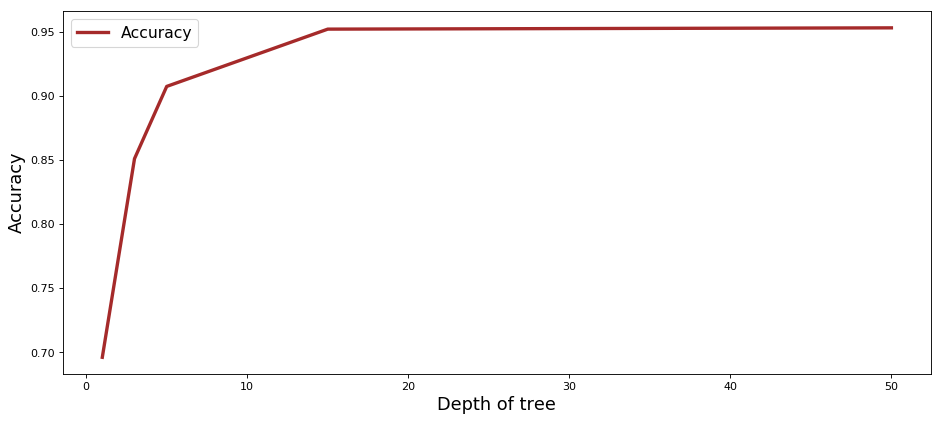

In [174]:
# запишем функцию построения графика зависимости accuracy от к-л параметра

def graph_accuracy(parametres, vector_accuracy, name_param):
    fig, axes = plt.subplots(figsize = (14,6), dpi = 80)
    plt.plot(parametres, vector_accuracy, color = 'brown', lw = 3, label = 'Accuracy')
    plt.xlabel(name_param, size = 16)
    plt.ylabel('Accuracy', size = 16)
    plt.legend(prop = {'size': 14})
    plt.show()

name_param = 'Depth of tree'
graph_accuracy(depth, vector_accuracy_1, name_param)

## Исследование 7
Оценим метрику качества accuracy ***при изменении количества деревьев*** в случайном лесе

Модель: случайный лес
Глубина: один объект в листе
Количество признаков: sqrt of d 


Количество деревьев: 1
Средняя оценка accuracy: 0.746

Количество деревьев: 2
Средняя оценка accuracy: 0.735

Количество деревьев: 3
Средняя оценка accuracy: 0.819

Количество деревьев: 5
Средняя оценка accuracy: 0.887

Количество деревьев: 10
Средняя оценка accuracy: 0.928

Количество деревьев: 50
Средняя оценка accuracy: 0.947

Количество деревьев: 100
Средняя оценка accuracy: 0.954


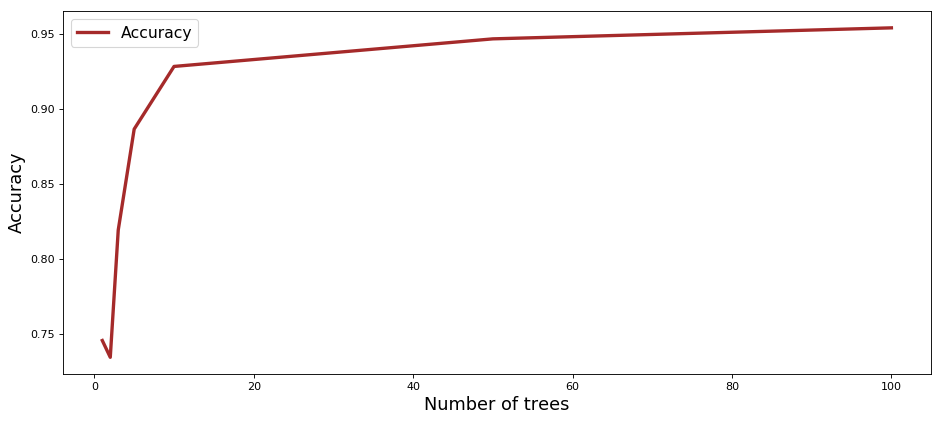

In [175]:
# запишем количество деревьев в лесу в вектор
trees = [1, 2, 3, 5, 10, 50, 100]

# запишем функцию определения метрики качества в зависимости от значений вектора 'trees'
def accuracy_from_trees(x_data, y, trees):
    print 'Модель: случайный лес'
    print 'Глубина: один объект в листе'
    print 'Количество признаков: sqrt of d','\n'
    vector_accuracy = []
    for i in trees:
        print '\n', 'Количество деревьев:', i
        model = ensemble.RandomForestClassifier(n_estimators = i, max_features = 'sqrt', max_depth = None)
        strategy_cv = model_selection.cross_val_score(model, x_data, y, cv = 10)
        mean_accuracy = np.mean(strategy_cv)
        print 'Средняя оценка accuracy:', round(mean_accuracy,3)
        vector_accuracy.append(mean_accuracy)
    return vector_accuracy

vector_accuracy_2 = accuracy_from_trees(x_data, y, trees)
name_param = 'Number of trees'

graph_accuracy(trees, vector_accuracy_2, name_param)

## Исследование 8 
Оценим метрику качества accuracy ***в зависимости от количества выбираемых признаков $d$***

Модель: случайный лес
Глубина: один объект в листе
Количество деревьев: 100 


Количество признаков: 1
Средняя оценка accuracy: 0.945

Количество признаков: 2
Средняя оценка accuracy: 0.95

Количество признаков: 3
Средняя оценка accuracy: 0.956

Количество признаков: 6
Средняя оценка accuracy: 0.954

Количество признаков: 8
Средняя оценка accuracy: 0.955

Количество признаков: 19
Средняя оценка accuracy: 0.948

Количество признаков: 32
Средняя оценка accuracy: 0.943

Количество признаков: 44
Средняя оценка accuracy: 0.941

Количество признаков: 57
Средняя оценка accuracy: 0.927

Количество признаков: 64
Средняя оценка accuracy: 0.926


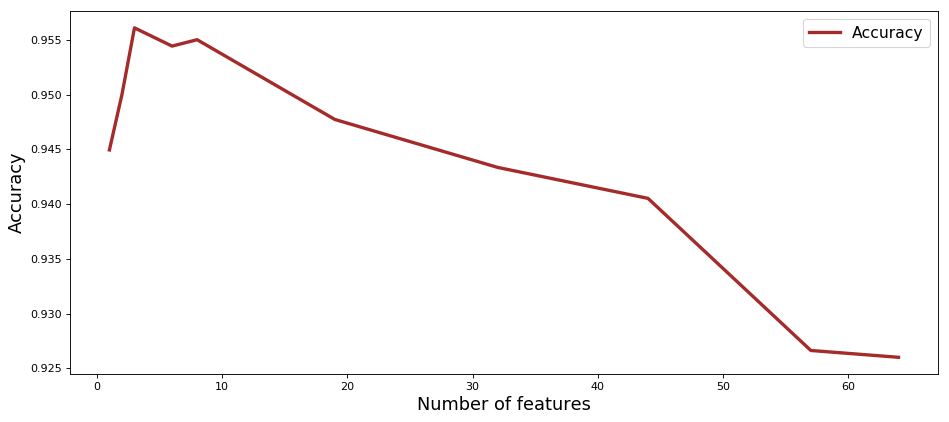

In [176]:
# запишем количество признаков для анализа в вектор
features = [1, 2, 3, int(x_data.shape[1]*0.1), int(x_data.shape[1]**0.5), int(x_data.shape[1]*0.3), int(x_data.shape[1]*0.5), 
            int(x_data.shape[1]*0.7), int(x_data.shape[1]*0.9), int(x_data.shape[1])]

# запишем функцию определения метрики качества в зависимости от значений вектора 'features'
def accuracy_from_features(x_data, y, features):
    print 'Модель: случайный лес'
    print 'Глубина: один объект в листе'
    print 'Количество деревьев: 100', '\n'
    vector_accuracy = []
    for i in features:
        print '\n', 'Количество признаков:', i
        model = ensemble.RandomForestClassifier(n_estimators = 100, max_features = i, max_depth = None)
        strategy_cv = model_selection.cross_val_score(model, x_data, y, cv = 10)
        mean_accuracy = np.mean(strategy_cv)
        print 'Средняя оценка accuracy:', round(mean_accuracy,3)
        vector_accuracy.append(mean_accuracy)
    return vector_accuracy

vector_accuracy_3 = accuracy_from_features(x_data, y, features)
name_param = 'Number of features'

graph_accuracy(features, vector_accuracy_3, name_param)

## Исследование 8
Разобьем выборку на обучающую и тестовую. На тестовой выборке с использованием кросс-валидации на 10 фолдов оценим метрику качества accuracy

In [180]:
# разобъем выборку на обучающую и тестовую с сохранением исходной пропорции классов в тестовой (stratify)
(x_train, x_test, y_train, y_test) = train_test_split(x_data, y, 
                                     test_size=0.3, random_state=0, stratify = y)

Проверим, что после разбиения выборки баланс классов объектов сохранился

In [182]:
# проверим балансировку классов объектов
balance = []
for i in np.unique(y_train):
    cell = np.array([])
    cell.resize((1,2))
    cell[0][0] = i
    cell[0][1] = np.sum(y_train==i)
    balance.append(cell)

balance

[array([[  0., 124.]]),
 array([[  1., 127.]]),
 array([[  2., 124.]]),
 array([[  3., 128.]]),
 array([[  4., 127.]]),
 array([[  5., 127.]]),
 array([[  6., 127.]]),
 array([[  7., 125.]]),
 array([[  8., 122.]]),
 array([[  9., 126.]])]

Баланс сохранился. Оценим Accuracy на обучающей выборке, на тестовой выборке, на тестовой выборке с использованием кросс-валидации на 10 фолдов. При этом, посмотрим как будет меняться качество в зависимости от количества деревьев в лесу. 

**Предположение 1**
Относительно accuracy на обучающей выборке мы изначально предполагаем, что оценка метрики качества при малом количестве деревьев (1, 2, 3) будет давать низкие результаты и с ростом количества деревьев качество модели будет расти. Но в связи с тем, что мы имеем дело с большим количеством независимых деревьев, предполагаем, что на обучающей выборке accuracy будет около 1, но не равно 1. Ведь если качество на обучающей выборке достигает 1, то это говорит о переобученности модели, а мы как раз используем модель и настраиваем параметры (бэггинг, кол-во признаков, кол-во деревьев) так, чтобы модель обладала хорошей обобщающей способностью.

**Предположение 2**
Мы считаем что качество модели (accuracy) на обучающей выборке будет самой высокой, на тестовой оценка метрики качества будет ниже, и при использовании кросс-валидации на тестовой выборке качество будет еще ниже. Это предположение мы считаем абсолютно справедливым для всех случаев.

**Предположение 3**
Мы считаем, что с ростом количества деревьев качество модели будет расти для всех случаев оценки accuracy.

In [220]:
# запишем значения количества деревьев в лесу в вектор
trees = [1, 2, 3, 5, 10, 50, 100, 500]

# напишем функцию возвращающую качество модели в зависимости от количества деревьев
def accuracy_for_train_test(x_train, x_test, y_train, y_test, trees):
    for tree in trees:
        print 'Number of trees:', tree, '\n'
        # инициилизируем класс "RandomForestClassifier"
        model = ensemble.RandomForestClassifier(n_estimators = tree, max_features = 'sqrt', max_depth = None)
        # обучим модель случайного леса
        model_fit = model.fit(x_train, y_train)

        # построим предсказания на обучающей выборке в соответствии обученной моделью
        predict_train = model_fit.predict(x_train)
        # оценим метрику качества 'Accuracy' на обучающей выборке
        accuracy_train = accuracy_score(y_train, predict_train)
        print 'Accuracy for train test:', round(accuracy_train, 3)

        # построим предсказания на тестовой выборке в соответствии с обученной моделью
        predict_test = model_fit.predict(x_test)
        # оценим 'Accuracy' на тестовой выборке
        accuracy_test = accuracy_score(y_test, predict_test)
        print 'Accuracy for test train:', round(accuracy_test, 3)

        # оценим качество 'Accuracy' на тестовой выборке с использованием кросс-валидации на 10 фолдов
        strategy_cv = model_selection.cross_val_score(model_fit, x_test, y_test, cv = 10)
        print 'Accuracy for test train with CV (k=10)', round(np.mean(strategy_cv), 3), '\n'

accuracy_for_train_test(x_train, x_test, y_train, y_test, trees)

Number of trees: 1 

Accuracy for train test: 0.916
Accuracy for test train: 0.75
Accuracy for test train with CV (k=10) 0.661 

Number of trees: 2 

Accuracy for train test: 0.91
Accuracy for test train: 0.772
Accuracy for test train with CV (k=10) 0.659 

Number of trees: 3 

Accuracy for train test: 0.971
Accuracy for test train: 0.844
Accuracy for test train with CV (k=10) 0.783 

Number of trees: 5 

Accuracy for train test: 0.994
Accuracy for test train: 0.881
Accuracy for test train with CV (k=10) 0.825 

Number of trees: 10 

Accuracy for train test: 1.0
Accuracy for test train: 0.948
Accuracy for test train with CV (k=10) 0.897 

Number of trees: 50 

Accuracy for train test: 1.0
Accuracy for test train: 0.972
Accuracy for test train with CV (k=10) 0.946 

Number of trees: 100 

Accuracy for train test: 1.0
Accuracy for test train: 0.976
Accuracy for test train with CV (k=10) 0.938 

Number of trees: 500 

Accuracy for train test: 1.0
Accuracy for test train: 0.976
Accuracy fo

Мы были правы в части второго и третьего предположения. Однако мы частично ошиблись с первым предположением. Мы установили, что качество модели, при росте количества деревьев растет и в итоге достигает 1, что противоречит нашим предположениям о хорошей обобщающей способности. Возможно это совпадение. 

#### Дополнительный эксперимент к исследованию №8
Давайте изменим модель. Возьмем одно дерево, не будем ограничивать глубину, количество объектов и признаков. Измерим качество модели на обучающей выборке, тестовой и тестовой с кросс-валидацией на 10 фолдов.

**Предположение 1**

Мы ожидаем увидеть качество на обучающей выборке = 1, качество на тестовой выборке и на тестовой выборке с кросс-валидацией ниже чем при ансамбле деревьев, так как модель из одного дерева должна обладать низкой обобщающей способностью.

In [221]:
# инициилизируем класс "DecisionTreeClassifier"
model = tree.DecisionTreeClassifier()
# обучим модель случайного леса
model_fit = model.fit(x_train, y_train)

# построим предсказания на обучающей выборке в соответствии обученной моделью
predict_train = model_fit.predict(x_train)
# оценим метрику качества 'Accuracy' на обучающей выборке
accuracy_train = accuracy_score(y_train, predict_train)
print 'Accuracy for train test:', round(accuracy_train, 3)

# построим предсказания на тестовой выборке в соответствии с обученной моделью
predict_test = model_fit.predict(x_test)
# оценим 'Accuracy' на тестовой выборке
accuracy_test = accuracy_score(y_test, predict_test)
print 'Accuracy for test train:', round(accuracy_test, 3)

# оценим качество 'Accuracy' на тестовой выборке с использованием кросс-валидации на 10 фолдов
strategy_cv = model_selection.cross_val_score(model_fit, x_test, y_test, cv = 10)
print 'Accuracy for test train with CV (k=10)', round(np.mean(strategy_cv), 3), '\n'

Accuracy for train test: 1.0
Accuracy for test train: 0.85
Accuracy for test train with CV (k=10) 0.803 



Наши предположения подтвердились относительно результатов дополнительного эксперимента подтвердились. Однако это не в полной мере объясняет accuracy = 1 на обучающей выборке в модели из ансамбля деревьев. 

Рекомендуется провести дополнительный эксперимент на ином дата-сете.

На данный момент исследование не завершено.